# Predicting points for fantasy defense
This notebook will complete the predictive model for FanDuel and DraftKings points for team defenses.<br>

The model results are stored in error_dict below. The keys are the names of the models. The values are the best parameters and the Root Mean Squared Error of the models with the best params on the test set.<br>

In [263]:
error_dict = {'KNN': [58, 6.061754105464961], 'Ridge': [{'alpha': 100.0}, 6.0157004862603936],\
              'Random Forest': [{'max_depth': 3, 'n_estimators': 100}, 6.031473513951821],\
              'Gradient Boost': [{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}, 6.025114773342712],\
              'XG Boost': [{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}, 6.02489434569588]}

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nfl_data_py as nfl

In [121]:
import sqlite3

# Connecting to the database
We import sqlite3 and connect to our database to retrieve our defense_df dataframe, which we used to derive the target variable for our defense model and will use again to extract some features, and also our defense_target dataframe, which contains the target variable for all team defenses.

In [122]:
# Connect to the SQLite database
conn = sqlite3.connect('nfl_dfs.db')

# Query specific columns from the table
query1 = "SELECT * FROM team_defense"
defense_df = pd.read_sql_query(query1, conn)

query2 = "SELECT * FROM defense_target"
defense_target = pd.read_sql_query(query2, conn)

# Close the connection
conn.close()

In [123]:
defense_df.head()

,id,Unnamed: 0,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,...,div_game,roof,surface,pass,rush,posteam_score,posteam_score_post,defteam_score,defteam_score_post,desc
0,0,0,34.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,0.0,0.0,NaN,0.0,NaN,0.0,B.Daluiso kicks 72 yards from NYG 30 to ARI -2...
1,1,1,70.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,0.0,0.0,0.0,0.0,0.0,0.0,B.Daluiso kicks 69 yards from NYG 25 to ARI 6....
2,2,2,106.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,0.0,1.0,0.0,0.0,0.0,0.0,(15:00) T.Jones left end to ARI 37 for 2 yards...
3,3,3,131.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,1.0,0.0,0.0,0.0,0.0,0.0,(14:04) J.Plummer pass incomplete to T.Jones.
4,4,4,148.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,1.0,0.0,0.0,0.0,0.0,0.0,(13:57) (Shotgun) J.Plummer pass incomplete to...


In [124]:
defense_target.head()

,season,week,game_id,defteam,FD_Pts,DK_Pts
0,2000,1,2000_01_ARI_NYG,ARI,4.0,4.0
1,2000,1,2000_01_ARI_NYG,NYG,10.0,10.0
2,2000,1,2000_01_BAL_PIT,BAL,13.0,13.0
3,2000,1,2000_01_BAL_PIT,PIT,2.0,2.0
4,2000,1,2000_01_CAR_WAS,CAR,7.0,7.0


In [125]:
defense_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135207 entries, 0 to 1135206
Data columns (total 67 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   id                             1135207 non-null  int64  
 1   Unnamed: 0                     1135207 non-null  int64  
 2   play_id                        1135207 non-null  float64
 3   game_id                        1135207 non-null  object 
 4   old_game_id                    1135207 non-null  int64  
 5   home_team                      1135207 non-null  object 
 6   away_team                      1135207 non-null  object 
 7   season_type                    1135207 non-null  object 
 8   week                           1135207 non-null  int64  
 9   posteam                        1071824 non-null  object 
 10  posteam_type                   1071888 non-null  object 
 11  defteam                        1071888 non-null  object 
 12  sp            

# Variables
## Point spread, over-under, indoors/outdoors, surface, home team
We need variables for point spread, over-under, whether the game was played outdoors or under a roof (indoor games tend to be more high-scoring), the playing surface and whether or not the defense was playing at home.<br>

We'll group our defense_df to get those variables. Then we'll create binary indicators for outdoor games, grass surfaces and home team. Then we'll break up the dataframe into home and away rows and then put it back together so that we have one row for each team in each game.

In [126]:
group_list = ['season', 'week', 'game_id', 'home_team', 'away_team']

In [127]:
spread_df = defense_df.groupby(group_list).agg({'spread_line': 'mean', 'total_line' : 'mean', 'roof': 'first', 'surface': 'first'}).reset_index()

In [128]:
spread_df = pd.DataFrame(spread_df)

In [129]:
spread_df.head(30)

,season,week,game_id,home_team,away_team,spread_line,total_line,roof,surface
0,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,outdoors,grass
1,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,outdoors,astroturf
2,2000,1,2000_01_CAR_WAS,WAS,CAR,10.5,47.5,outdoors,grass
3,2000,1,2000_01_CHI_MIN,MIN,CHI,4.5,46.5,dome,astroturf
4,2000,1,2000_01_DEN_STL,LA,DEN,6.5,48.5,dome,astroturf
5,2000,1,2000_01_DET_NO,NO,DET,0.0,40.5,dome,astroturf
6,2000,1,2000_01_IND_KC,KC,IND,-3.5,44.0,outdoors,grass
7,2000,1,2000_01_JAX_CLE,CLE,JAX,-10.5,38.5,outdoors,grass
8,2000,1,2000_01_NYJ_GB,GB,NYJ,2.5,44.0,outdoors,grass
9,2000,1,2000_01_PHI_DAL,DAL,PHI,6.0,39.5,outdoors,astroturf


In [130]:
spread_df['roof'] = np.where((spread_df['roof'] == 'outdoors') | (spread_df['roof'] == 'open'), 1, 0)
spread_df['surface'] = np.where((spread_df['surface'] == 'grass') | (spread_df['surface'] == 'grass '), 1, 0)
spread_df['home'] = 0

In [131]:
spread_df['surface'].value_counts()

surface
1    3687
0    2758
Name: count, dtype: int64

# Opponents vs. opposing defenses
We'll engineer features that look at how many fantasy points teams tend to yield against opposing defenses.<br>

First we'll create copies of spread_df so we can derive binary variables to indicate home team. Then we're going to look at how many fantasy points were scored by opposing defenses against each offense over the previous eight games. That's half a season. For Week 1, all we have to go on are the last eight games of the previous season. We're going to calculate the mean fantasy points scored by defenses against a team over the previous eight games. We'll get a straight-up mean, then a weighted mean that places more weight on more recent games. That way as the season progresses, games from the current season will carry more weight than games from last season. Even when all 8 games we look at are from the current season, more recent games should weigh more because things can change over the course of a season.<br>

We'll have linear and exponential weights.

In [132]:
spread_df_H = spread_df.copy()
spread_df_A = spread_df.copy()

In [133]:
# Assign new column 'def_team' and keep only necessary columns for each new row
spread_df_H['defteam'] = spread_df_H['home_team']
spread_df_H['opponent'] = spread_df_H['away_team']
spread_df_H = spread_df_H[['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']]
spread_df_H.columns = ['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']
spread_df_H['home_team'] = 1

spread_df_A['defteam'] = spread_df_A['away_team']
spread_df_A['opponent'] = spread_df_A['home_team']
spread_df_A = spread_df_A[['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']]
spread_df_A.columns = ['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']
spread_df_A['home_team'] = 0

In [134]:
#Point spread needs to be negated for away team since it's from perspective of home team
spread_df_A['spread_line'] = np.where(spread_df_A['spread_line'] == 0, 0, -spread_df_A['spread_line'])

In [135]:
spread_df_A.head()

,season,week,game_id,defteam,opponent,spread_line,total_line,roof,surface,home_team
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0
1,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0
2,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0
3,2000,1,2000_01_CHI_MIN,CHI,MIN,-4.5,46.5,0,0,0
4,2000,1,2000_01_DEN_STL,DEN,LA,-6.5,48.5,0,0,0


In [136]:
spread_df_H.head()

,season,week,game_id,defteam,opponent,spread_line,total_line,roof,surface,home_team
0,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1
1,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1
2,2000,1,2000_01_CAR_WAS,WAS,CAR,10.5,47.5,1,1,1
3,2000,1,2000_01_CHI_MIN,MIN,CHI,4.5,46.5,0,0,1
4,2000,1,2000_01_DEN_STL,LA,DEN,6.5,48.5,0,0,1


In [137]:
spread_df = pd.concat([spread_df_A, spread_df_H])

In [138]:
spread_df = spread_df.sort_values(['season', 'week', 'game_id', 'defteam']).reset_index(drop = True)

In [139]:
spread_df.rename(columns = {'roof': 'outdoors', 'surface' : 'grass'}, inplace = True)

In [140]:
spread_df.head(10)

,season,week,game_id,defteam,opponent,spread_line,total_line,outdoors,grass,home_team
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0
1,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1
2,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0
3,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1
4,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0
5,2000,1,2000_01_CAR_WAS,WAS,CAR,10.5,47.5,1,1,1
6,2000,1,2000_01_CHI_MIN,CHI,MIN,-4.5,46.5,0,0,0
7,2000,1,2000_01_CHI_MIN,MIN,CHI,4.5,46.5,0,0,1
8,2000,1,2000_01_DEN_STL,DEN,LA,-6.5,48.5,0,0,0
9,2000,1,2000_01_DEN_STL,LA,DEN,6.5,48.5,0,0,1


# Opponent Total
We're also going to derive the predicted points for each defense's opponent by dividing the total_line by 2, then subtracting half of the spread line from that. For example, in the first row of the dataframe, ARI is a 6.5-point underdog with the total_line at 40. So spread line for ARI is -6.5. Then 20 - (-6.5/2) is 20 + 3.25 = 23.25. So Arizona's defense faces a team predicted to score 23.25 points.

In [141]:
spread_df['opp_total'] = np.round((spread_df['total_line']/2) - (spread_df['spread_line']/2), 2)

# Merging the target variable into our data
This adds FD_Pts and DK_Pts columns.

In [142]:
def_model = pd.merge(spread_df, defense_target, on = ['season', 'week', 'game_id', 'defteam'], how = 'left')

In [143]:
def_model.head(10)

,season,week,game_id,defteam,opponent,spread_line,total_line,outdoors,grass,home_team,opp_total,FD_Pts,DK_Pts
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0,23.25,4.0,4.0
1,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1,16.75,10.0,10.0
2,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0,17.25,13.0,13.0
3,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1,19.75,2.0,2.0
4,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0,29.00,7.0,7.0
5,2000,1,2000_01_CAR_WAS,WAS,CAR,10.5,47.5,1,1,1,18.50,9.0,9.0
6,2000,1,2000_01_CHI_MIN,CHI,MIN,-4.5,46.5,0,0,0,25.50,2.0,2.0
7,2000,1,2000_01_CHI_MIN,MIN,CHI,4.5,46.5,0,0,1,21.00,4.0,4.0
8,2000,1,2000_01_DEN_STL,DEN,LA,-6.5,48.5,0,0,0,27.50,10.0,10.0
9,2000,1,2000_01_DEN_STL,LA,DEN,6.5,48.5,0,0,1,21.00,9.0,9.0


# Just one target
There are 26 cases where FD_Pts differs from DK_Pts because of the little DK scoring quirk in which a fantasy defense earns a point when that team loses a fumble on offense and then regains possession after forcing the defensive team to fumble on the same play. Those 26 data points account for .2 percent of all the data points. That's one-fifth of one percent. So let's create a single target variable that is the mean of FD_Pts and DK_Pts, because in almost all cases the scores are identical anyway.

In [144]:
diff_scores = def_model[def_model['FD_Pts'] != def_model['DK_Pts']]

In [145]:
len(diff_scores)/len(def_model)

0.002017067494181536

In [146]:
def_model['fantasy_points'] = def_model[['FD_Pts', 'DK_Pts']].mean(axis=1)

In [147]:
def_model.drop(columns = ['FD_Pts', 'DK_Pts'], inplace = True)

In [148]:
def_model.head()

,season,week,game_id,defteam,opponent,spread_line,total_line,outdoors,grass,home_team,opp_total,fantasy_points
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0,23.25,4.0
1,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1,16.75,10.0
2,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0,17.25,13.0
3,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1,19.75,2.0
4,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0,29.00,7.0


# Checking distribution
Let's create a histogram to make sure that we didn't screw anything up.

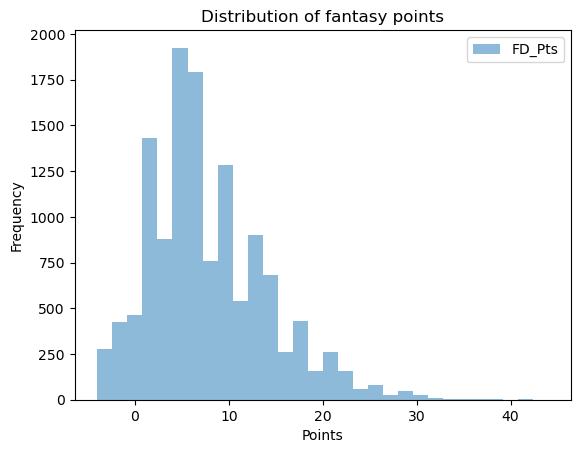

In [149]:
plt.hist(def_model['fantasy_points'], bins=30, alpha=0.5, label='FD_Pts')

# Adding titles and labels
plt.title('Distribution of fantasy points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

This is where we create that dataframe to derive fantasy points against opponents.

In [150]:
opp_vs_def = def_model[['season', 'week', 'game_id', 'opponent', 'fantasy_points']]

In [151]:
opp_vs_def = opp_vs_def.sort_values(by=['opponent', 'season', 'week', 'game_id'])

In [152]:
opp_vs_def['game_num'] = opp_vs_def.groupby(['opponent', 'season']).cumcount() + 1

In [153]:
opp_vs_def

,season,week,game_id,opponent,fantasy_points,game_num
1,2000,1,2000_01_ARI_NYG,ARI,10.0,1
39,2000,2,2000_02_DAL_ARI,ARI,9.0,2
93,2000,4,2000_04_GB_ARI,ARI,16.0,3
115,2000,5,2000_05_ARI_SF,ARI,5.0,4
145,2000,6,2000_06_CLE_ARI,ARI,4.0,5
...,...,...,...,...,...,...
12700,2023,13,2023_13_MIA_WAS,WAS,12.0,13
12766,2023,15,2023_15_WAS_LA,WAS,6.0,14
12798,2023,16,2023_16_WAS_NYJ,WAS,8.0,15
12828,2023,17,2023_17_SF_WAS,WAS,9.0,16


# Giving recent games more weight
In Week 1, the only data we have to go on will be data from last season. A lot can change between seasons, but that's all we have. So to create features for the points that fantasy defenses score against opponents, we'll create a weighted mean. That way when we get into subsequent weeks, games from the current season will have more weight than games from last season.<br>

We're going to take the rolling weight mean of the last eight games. We'll have a mean of equal weights, a mean with linear weights and a mean with exponential weights. We're using the last eight games because that's basically half a season. A lot can change over the course of one season. When we get into the second half of a season, we won't be using data from the previous season. Then when we get later in the season, we won't have data from the early weeks of the season. We want data that looks at the current conditions as much as possible.

In [154]:
# Function to calculate equally weighted rolling mean
def calculate_equal_rolling_mean(group):
    # Calculate the equally weighted rolling mean of the last 8 games, excluding the current game
    group['rolling_mean_8'] = (
        group['fantasy_points'].shift().rolling(window=8, min_periods=1).mean()
    )
    return group

# Apply the rolling mean calculation using groupby
opp_vs_def = opp_vs_def.groupby('opponent', group_keys=False).apply(calculate_equal_rolling_mean)


In [155]:
# Linear and Exponential weights
# linear_weights = np.array([0.25, 0.20, 0.15, 0.13, 0.10, 0.08, 0.05, 0.04])
# exponential_weights = np.array([0.27, 0.23, 0.19, 0.15, 0.11, 0.09, 0.07, 0.05])

# Corrected Linear and Exponential weights
linear_weights = np.array([0.01, 0.03, 0.06, 0.10, 0.14, 0.18, 0.24, 0.28])
exponential_weights = np.array([0.015, 0.025, 0.04, 0.07, 0.10, 0.15, 0.25, 0.35])

In [156]:
# Function to calculate rolling means with different weights
def calculate_weighted_means(group):
    # Calculate the linear weighted rolling mean
    group['linear_rolling_mean_8'] = (
        group['fantasy_points'].shift().rolling(window=8, min_periods=1)
        .apply(lambda x: np.dot(x, linear_weights[-len(x):]), raw=False)
    )
    
    # Calculate the exponential weighted rolling mean
    group['exponential_rolling_mean_8'] = (
        group['fantasy_points'].shift().rolling(window=8, min_periods=1)
        .apply(lambda x: np.dot(x, exponential_weights[-len(x):]), raw=False)
    )
    return group

In [157]:
# Apply the calculations using groupby
opp_vs_def = opp_vs_def.groupby('opponent', group_keys=False).apply(calculate_weighted_means)

In [158]:
opp_vs_def.rename(columns = {'rolling_mean_8': 'opp_vs_def_L8',\
                             'linear_rolling_mean_8': 'opp_vs_def_L8_lin',\
                            'exponential_rolling_mean_8': 'opp_vs_def_L8_exp'}, inplace = True)

In [159]:
opp_vs_def.drop(columns = ['fantasy_points', 'game_num'], inplace = True)

In [160]:
opp_vs_def

,season,week,game_id,opponent,opp_vs_def_L8,opp_vs_def_L8_lin,opp_vs_def_L8_exp
1,2000,1,2000_01_ARI_NYG,ARI,NaN,NaN,NaN
39,2000,2,2000_02_DAL_ARI,ARI,10.000000,NaN,NaN
93,2000,4,2000_04_GB_ARI,ARI,9.500000,NaN,NaN
115,2000,5,2000_05_ARI_SF,ARI,11.666667,NaN,NaN
145,2000,6,2000_06_CLE_ARI,ARI,10.000000,NaN,NaN
...,...,...,...,...,...,...,...
12700,2023,13,2023_13_MIA_WAS,WAS,10.375000,13.31,13.875
12766,2023,15,2023_15_WAS_LA,WAS,10.625000,13.43,13.215
12798,2023,16,2023_16_WAS_NYJ,WAS,10.750000,11.84,10.730
12828,2023,17,2023_17_SF_WAS,WAS,10.000000,10.94,9.740


In [161]:
def_model = pd.merge(def_model, opp_vs_def, on = ['season', 'week', 'game_id', 'opponent'], how = 'left')

In [162]:
def_model.head()

,season,week,game_id,defteam,opponent,spread_line,total_line,outdoors,grass,home_team,opp_total,fantasy_points,opp_vs_def_L8,opp_vs_def_L8_lin,opp_vs_def_L8_exp
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0,23.25,4.0,NaN,NaN,NaN
1,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1,16.75,10.0,NaN,NaN,NaN
2,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0,17.25,13.0,NaN,NaN,NaN
3,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1,19.75,2.0,NaN,NaN,NaN
4,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0,29.00,7.0,NaN,NaN,NaN


In [163]:
def_model.drop(columns = ['opponent'], inplace = True)

In [164]:
def_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12890 entries, 0 to 12889
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season             12890 non-null  int64  
 1   week               12890 non-null  int64  
 2   game_id            12890 non-null  object 
 3   defteam            12890 non-null  object 
 4   spread_line        12890 non-null  float64
 5   total_line         12890 non-null  float64
 6   outdoors           12890 non-null  int32  
 7   grass              12890 non-null  int32  
 8   home_team          12890 non-null  int64  
 9   opp_total          12890 non-null  float64
 10  fantasy_points     12890 non-null  float64
 11  opp_vs_def_L8      12858 non-null  float64
 12  opp_vs_def_L8_lin  12634 non-null  float64
 13  opp_vs_def_L8_exp  12634 non-null  float64
dtypes: float64(7), int32(2), int64(3), object(2)
memory usage: 1.3+ MB


In [165]:
def_model.dropna(inplace = True)

In [166]:
def_model.set_index(['season', 'week', 'game_id', 'defteam'], inplace = True)

In [167]:
def_model.head()

spread_line  total_line  outdoors  grass  \
season week game_id         defteam                                             
2000   9    2000_09_CAR_ATL CAR              3.0        45.5         0      0   
            2000_09_CIN_CLE CIN              3.0        35.5         1      1   
            2000_09_JAX_DAL DAL              4.0        44.5         1      0   
            2000_09_KC_SEA  KC               4.0        43.0         1      0   
            2000_09_PHI_NYG NYG              3.5        37.0         1      1   

                                     home_team  opp_total  fantasy_points  \
season week game_id         defteam                                         
2000   9    2000_09_CAR_ATL CAR              0      21.25            11.0   
            2000_09_CIN_CLE CIN              0      16.25            13.0   
            2000_09_JAX_DAL DAL              1      20.25             2.0   
            2000_09_KC_SEA  KC               0      19.50            12.0   
            2000_09_PHI_NYG NYG              1      16.75            10.0   

                                     opp_vs_def_L8  opp_vs_def_L8_lin  \
season week game_id         defteam                                     
2000   9    2000_09_CAR_ATL CAR              12.25              13.04   
            2000_09_CIN_CLE CIN              11.00              14.68   
            2000_09_JAX_DAL DAL              12.00              14.92   
            2000_09_KC_SEA  KC               12.75              12.53   
            2000_09_PHI_NYG NYG               8.00               8.02   

                                     opp_vs_def_L8_exp  
season week game_id         defteam                     
2000   9    2000_09_CAR_ATL CAR                 11.580  
            2000_09_CIN_CLE CIN                 14.740  
            2000_09_JAX_DAL DAL                 14.350  
            2000_09_KC_SEA  KC                  12.555  
            2000_09_PHI_NYG NYG                  7.490

# Exploratory Data Analysis
We have 10 features so let's do some EDA.<br>

Things make sense here. The spread is symmetrical. Minimum fantasy points is -4 because allowing points is the only way points can be deducted from a fantasy defense and both sides subtract four for allowing 35 points or more.<br>

First we'll import sklearn.

In [168]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 

In [169]:
def_model.describe()

,spread_line,total_line,outdoors,grass,home_team,opp_total,fantasy_points,opp_vs_def_L8,opp_vs_def_L8_lin,opp_vs_def_L8_exp
count,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000
mean,-0.005699,43.635112,0.756609,0.570524,0.499683,21.820405,7.711334,7.729871,8.032965,7.723007
std,6.389072,4.934458,0.429146,0.495021,0.500020,4.032800,6.344523,2.848455,3.353193,3.429885
min,-27.000000,28.500000,0.000000,0.000000,0.000000,9.500000,-4.000000,-1.000000,-1.890000,-2.335000
25%,-4.000000,40.500000,1.000000,0.000000,0.000000,19.000000,3.000000,5.750000,5.632500,5.270000
50%,0.000000,43.500000,1.000000,1.000000,0.000000,21.750000,7.000000,7.562500,7.790000,7.430000
75%,4.000000,47.000000,1.000000,1.000000,1.000000,24.750000,11.000000,9.625000,10.120000,9.845000
max,27.000000,63.500000,1.000000,1.000000,1.000000,40.000000,44.000000,18.250000,22.670000,24.045000


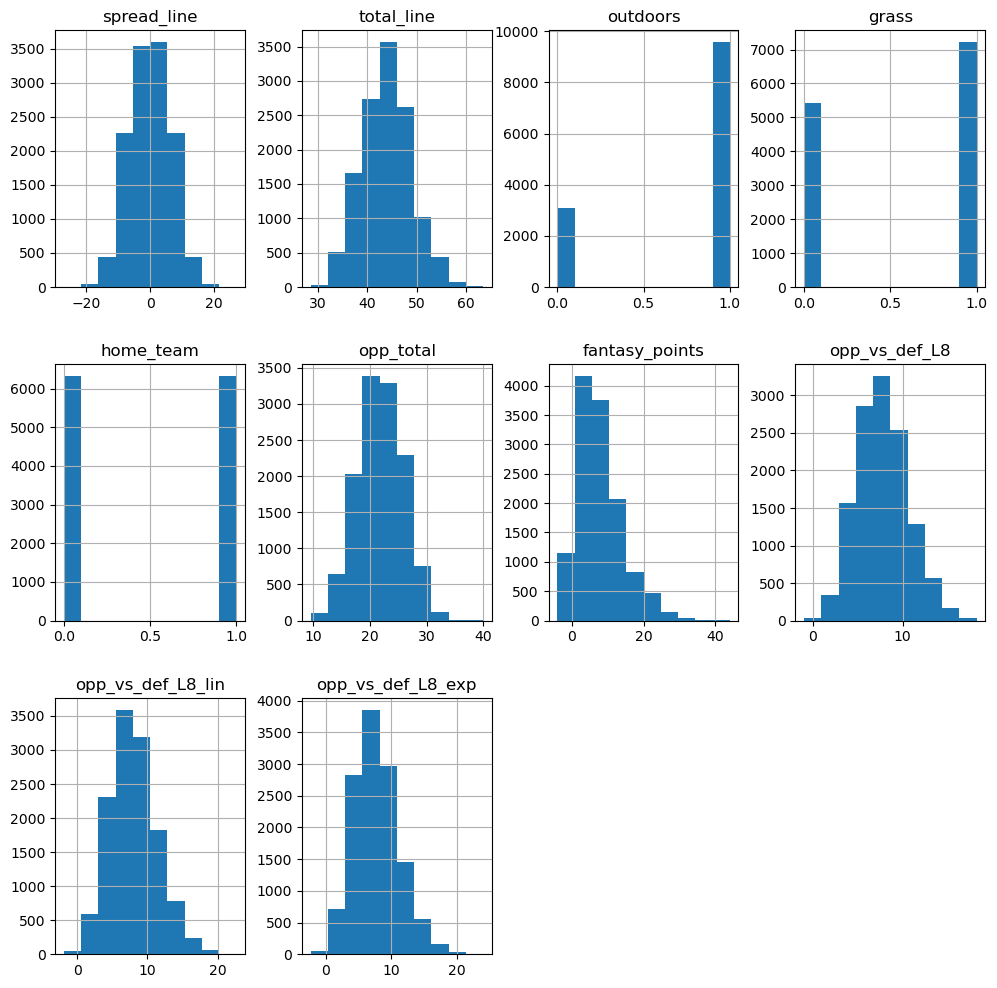

In [170]:
def_model.hist(layout = (3, 4), figsize = (12, 12))
#plt.subplots_adjust(hspace=1)
plt.show();

# High totals
We're checking over-unders higher than 60 to make sure there are no errors.<br>

This makes sense. Patrick Mahomes going up against a Rams team that made the Super Bowl that year. The Kurt Warner Rams in 2000. Drew Brees vs. Matt Ryan in the Superdome in 2018.

In [171]:
def_model[def_model['total_line'] > 60]

spread_line  total_line  outdoors  grass  \
season week game_id        defteam                                             
2000   9    2000_09_STL_SF LA               7.0        63.0         1      1   
2018   11   2018_11_KC_LA  KC              -3.0        63.5         1      1   
                           LA               3.0        63.5         1      1   
       12   2018_12_ATL_NO ATL            -11.5        61.0         0      0   
                           NO              11.5        61.0         0      0   

                                    home_team  opp_total  fantasy_points  \
season week game_id        defteam                                         
2000   9    2000_09_STL_SF LA               0      28.00             2.0   
2018   11   2018_11_KC_LA  KC               0      33.25            11.0   
                           LA               1      30.25            21.0   
       12   2018_12_ATL_NO ATL              0      36.25             3.0   
                           NO               1      24.75            15.0   

                                    opp_vs_def_L8  opp_vs_def_L8_lin  \
season week game_id        defteam                                     
2000   9    2000_09_STL_SF LA               4.500               5.85   
2018   11   2018_11_KC_LA  KC               0.875               0.30   
                           LA               1.500               2.25   
       12   2018_12_ATL_NO ATL             -1.000              -1.89   
                           NO               4.375               5.06   

                                    opp_vs_def_L8_exp  
season week game_id        defteam                     
2000   9    2000_09_STL_SF LA                   6.575  
2018   11   2018_11_KC_LA  KC                  -0.160  
                           LA                   2.395  
       12   2018_12_ATL_NO ATL                 -2.335  
                           NO                   5.020

In [172]:
def_model[def_model['opp_total'] == 40]

,,,,spread_line,total_line,outdoors,grass,home_team,opp_total,fantasy_points,opp_vs_def_L8,opp_vs_def_L8_lin,opp_vs_def_L8_exp
season,week,game_id,defteam,,,,,,,,,,
2013,6,2013_06_JAX_DEN,JAX,-27.0,53.0,1,1,0,40.0,8.0,0.875,-0.11,-0.325


In [173]:
def_model.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12634 entries, (2000, 9, '2000_09_CAR_ATL', 'CAR') to (2023, 22, '2023_22_SF_KC', 'SF')
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   spread_line        12634 non-null  float64
 1   total_line         12634 non-null  float64
 2   outdoors           12634 non-null  int32  
 3   grass              12634 non-null  int32  
 4   home_team          12634 non-null  int64  
 5   opp_total          12634 non-null  float64
 6   fantasy_points     12634 non-null  float64
 7   opp_vs_def_L8      12634 non-null  float64
 8   opp_vs_def_L8_lin  12634 non-null  float64
 9   opp_vs_def_L8_exp  12634 non-null  float64
dtypes: float64(7), int32(2), int64(1)
memory usage: 1.2+ MB


In [174]:
corr_df = def_model.corr()

In [175]:
corr_df['fantasy_points'].sort_values(ascending = False)

fantasy_points       1.000000
spread_line          0.241202
opp_vs_def_L8        0.189576
opp_vs_def_L8_lin    0.170907
opp_vs_def_L8_exp    0.159548
home_team            0.074004
outdoors             0.042573
grass                0.027881
total_line          -0.160199
opp_total           -0.289074
Name: fantasy_points, dtype: float64

# No strong correlations
Confession: The feature with the strongest correlation is opp_total, and that's the last one we added to the model. None of these correlations are that great, but opp_total is the strongest with a negative correlation of .29. The more points an opponent is expected to score, the less points that fantasy defense is expected to score.<br>

# Putting 2023 aside
Before we start modeling, let's put 2023 aside because we might want to use it to run tests to make sure we can use this live. We'll rename def_model main_df so that we still have the 2023 data.

In [176]:
main_df = def_model.loc[def_model.index.get_level_values('season') != 2023]

In [177]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12064 entries, (2000, 9, '2000_09_CAR_ATL', 'CAR') to (2022, 22, '2022_22_KC_PHI', 'PHI')
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   spread_line        12064 non-null  float64
 1   total_line         12064 non-null  float64
 2   outdoors           12064 non-null  int32  
 3   grass              12064 non-null  int32  
 4   home_team          12064 non-null  int64  
 5   opp_total          12064 non-null  float64
 6   fantasy_points     12064 non-null  float64
 7   opp_vs_def_L8      12064 non-null  float64
 8   opp_vs_def_L8_lin  12064 non-null  float64
 9   opp_vs_def_L8_exp  12064 non-null  float64
dtypes: float64(7), int32(2), int64(1)
memory usage: 1.2+ MB


# Model preprocessing
* We split the dataset into a features (X) and target (y).<br>
* We split into train and test sets.<br>
* We scale the features.<br>
* We predict the target variable using Linear Regression.<br>

In [178]:
X = main_df[['spread_line', 'home_team', 'outdoors', 'grass', 'total_line', 'opp_total', 'opp_vs_def_L8', 'opp_vs_def_L8_lin', 'opp_vs_def_L8_exp']]

In [179]:
y = main_df[['fantasy_points']]

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 43)

In [181]:
from sklearn.preprocessing import StandardScaler

In [182]:
scaler = StandardScaler()

In [183]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [184]:
X_scaled_df = pd.DataFrame(X_train_scaled, columns = X.columns)

In [185]:
X_scaled_df.mean()

spread_line          3.239684e-17
home_team            2.135247e-17
outdoors            -1.322170e-16
grass               -7.489141e-17
total_line           5.427523e-16
opp_total           -1.615635e-16
opp_vs_def_L8        3.954939e-17
opp_vs_def_L8_lin    2.781080e-16
opp_vs_def_L8_exp    2.436074e-16
dtype: float64

In [186]:
X_scaled_df.std()

spread_line          1.000059
home_team            1.000059
outdoors             1.000059
grass                1.000059
total_line           1.000059
opp_total            1.000059
opp_vs_def_L8        1.000059
opp_vs_def_L8_lin    1.000059
opp_vs_def_L8_exp    1.000059
dtype: float64

# The models
As of Aug. 13, we're thinking that we'll run the models through Linear Regression, KNN, Random Forest, Gradient Boost and XG Boost. The best three models will be used so that we have three predictions. We can use the minimum point total as the floor, the max as the ceiling and the middle as the baseline prediction.<br>

We'll use Root Mean Squared Error as the loss function and store the best RMSE of each model in error_dict.

In [187]:
from collections import defaultdict

In [188]:
error_dict = defaultdict(float)

In [189]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [190]:
from sklearn.metrics import mean_absolute_error

# K Nearest Neighbors

In [191]:
knn = KNeighborsRegressor()

In [192]:
# Lists to store the RMSE values and corresponding number of neighbors
rmse_list = []
neighbors_list = []

# Loop over a range of 1 to 80 neighbors
for i in range(1, 81):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    
    # Calculate and print the errors
    # print(f"Mean Absolute Error with {i} neighbors: {mean_absolute_error(y_test, y_pred)}")
    # print(f"Mean Squared Error with {i} neighbors: {mean_squared_error(y_test, y_pred)}")
    # print(f"Root Mean Squared Error with {i} neighbors: {mean_squared_error(y_test, y_pred, squared=False)}")
    # print()
    
    # Append the results to the lists
    rmse_list.append(mean_squared_error(y_test, y_pred, squared=False))
    neighbors_list.append(i)

# Combine the lists into a dictionary and sort by RMSE
knn_dict = dict(zip(neighbors_list, rmse_list))
sorted_knn = dict(sorted(knn_dict.items(), key=lambda item: item[1]))

In [193]:
for i, (k, v) in enumerate(sorted_knn.items()):
    neighbors = k
    best_rmse = v
    print(f"{k}: {v}")
    break

58: 6.061754105464961


In [194]:
error_dict['KNN'] = [neighbors, min(rmse_list)]

# Linear Regression

In [195]:
base_LR = LinearRegression()

In [196]:
base_LR.fit(X_train_scaled, y_train)

LinearRegression()

In [197]:
base_LR_pred = base_LR.predict(X_test_scaled)

In [198]:
print(f"R_squared_train: {base_LR.score(X_train_scaled, y_train)}")
print(f"R_squared_test: {base_LR.score(X_test_scaled, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, base_LR_pred)}")
print(f"MSE: {mean_squared_error(y_test, base_LR_pred)}")
print(f"RMSE: {mean_squared_error(y_test, base_LR_pred, squared = False)}")

R_squared_train: 0.08508740793948633
R_squared_test: 0.0910653631248024
MAE: 4.682865052850021
MSE: 36.1939524983443
RMSE: 6.016140997212773


# Ridge Regularization

In [199]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [200]:
alpha_values = np.linspace(0.1, 100, 50)

In [201]:
alpha_values = list(alpha_values)

In [202]:
param_grid = {'alpha': alpha_values}
Ridge_LR = Ridge()
Ridge_CV = GridSearchCV(Ridge_LR, param_grid, cv = 5, scoring = 'neg_root_mean_squared_error')
Ridge_CV.fit(X_train_scaled, y_train)
best_params = Ridge_CV.best_params_
best_score = -Ridge_CV.best_score_
print(f"Ridge_model best params: {best_params}")
print(f"Ridge_model best score: {best_score}")

Ridge_model best params: {'alpha': 100.0}
Ridge_model best score: 6.107948630074916


In [203]:
best_Ridge = Ridge(alpha = 100)
best_Ridge.fit(X_train_scaled, y_train)  # Correct the variable name for consistency
y_pred = best_Ridge.predict(X_test_scaled)  # Correct the variable name for consistency

best_rmse = mean_squared_error(y_test, y_pred, squared = False)
print(f"Best_Ridge Ridge R-squared: {best_Ridge.score(X_train_scaled, y_train)}")
print(f"Best_Ridge Test R-squared: {best_Ridge.score(X_test_scaled, y_test)}")
print(f"Best_Ridge MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Best_Ridge RMSE: {best_rmse}")
print(f"Best_Ridge MSE: {mean_squared_error(y_test, y_pred)}")

Best_Ridge Ridge R-squared: 0.0850270977154669
Best_Ridge Test R-squared: 0.0911984653921657
Best_Ridge MAE: 4.6827880279172875
Best_Ridge RMSE: 6.0157004862603936
Best_Ridge MSE: 36.18865234039353


In [204]:
error_dict['Ridge'] = [best_params, best_rmse]

In [205]:
error_dict

defaultdict(float,
            {'KNN': [58, 6.061754105464961],
             'Ridge': [{'alpha': 100.0}, 6.0157004862603936]})

# Random Forest

In [206]:
from sklearn.ensemble import RandomForestRegressor

In [207]:
base_RF = RandomForestRegressor(random_state = 43)

In [208]:
base_RF.fit(X_train_scaled, y_train)

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=43)

In [209]:
base_RF_pred = base_RF.predict(X_test_scaled)

In [210]:
print(f"R_squared_train: {base_RF.score(X_train_scaled, y_train)}")
print(f"R_squared_test: {base_RF.score(X_test_scaled, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, base_RF_pred)}")
print(f"MSE: {mean_squared_error(y_test, base_RF_pred)}")
print(f"RMSE: {mean_squared_error(y_test, base_RF_pred, squared = False)}")

R_squared_train: 0.8612201524444063
R_squared_test: 0.012064035407775342
MAE: 4.904791436464088
MSE: 39.33980060082873
RMSE: 6.272144816633999


In [211]:
from sklearn.metrics import make_scorer

In [212]:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [215]:
param_grid = {'max_depth': [2, 3, 4], 'n_estimators': [100, 200, 300]}
RF_CV = GridSearchCV(base_RF, param_grid, scoring=rmse_scorer, cv = 5, n_jobs = 2, verbose = 3)
RF_CV.fit(X_train_scaled, y_train)

best_params = RF_CV.best_params_
print(f"Tuned Random Forest Best Estimator: {RF_CV.best_estimator_}")
print(f"Tuned Random Forest Best Score: {RF_CV.best_score_}")
print(f"Tuned Random Forest Best Params: {RF_CV.best_params_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Tuned Random Forest Best Estimator: RandomForestRegressor(max_depth=3, random_state=43)
Tuned Random Forest Best Score: -6.11245646053143
Tuned Random Forest Best Params: {'max_depth': 3, 'n_estimators': 100}


In [216]:
best_RF = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=43)
best_RF.fit(X_train_scaled, y_train)  # Correct the variable name for consistency
y_pred = best_RF.predict(X_test_scaled)  # Correct the variable name for consistency

best_rmse = mean_squared_error(y_test, y_pred, squared = False)
print(f"Best_RF Train R-squared: {best_RF.score(X_train_scaled, y_train)}")
print(f"Best_RF Test R-squared: {best_RF.score(X_test_scaled, y_test)}")
print(f"Best_RF MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Best_RF RMSE: {best_rmse}")
print(f"Best_RF MSE: {mean_squared_error(y_test, y_pred)}")

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best_RF Train R-squared: 0.09355276182212968
Best_RF Test R-squared: 0.08642650434259302
Best_RF MAE: 4.690376854282536
Best_RF RMSE: 6.031473513951821
Best_RF MSE: 36.37867274950233


In [217]:
error_dict["Random Forest"] = [best_params, best_rmse]

# Gradient Boost

In [219]:
from sklearn.ensemble import GradientBoostingRegressor

In [220]:
base_GB = GradientBoostingRegressor(random_state = 43)

In [221]:
base_GB.fit(X_train_scaled, y_train)

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(random_state=43)

In [222]:
base_GB_pred = base_GB.predict(X_test_scaled)

In [223]:
print(f"Base GB R_squared_train: {base_GB.score(X_train_scaled, y_train)}")
print(f"Base GB R_squared_test: {base_GB.score(X_test_scaled, y_test)}")
print(f"Base GB MAE: {mean_absolute_error(y_test, base_GB_pred)}")
print(f"Base GB MSE: {mean_squared_error(y_test, base_GB_pred)}")
print(f"Base GB RMSE: {mean_squared_error(y_test, base_GB_pred, squared = False)}")

Base GB R_squared_train: 0.1410630027255354
Base GB R_squared_test: 0.0805524542359165
Base GB MAE: 4.696972518282876
Base GB MSE: 36.61257855736641
Base GB RMSE: 6.0508328812954675


In [224]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

In [225]:
GB_CV = GridSearchCV(base_GB, param_grid, scoring=rmse_scorer, cv = 5, n_jobs = 2, verbose = 3)
GB_CV.fit(X_train_scaled, y_train)
best_params = GB_CV.best_params_
print(f"Tuned Gradient Boost Best Estimator: {GB_CV.best_estimator_}")
print(f"Tuned Gradient Boost Best Score: {GB_CV.best_score_}")
print(f"Tuned Gradient Boost Best Params: {GB_CV.best_params_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Tuned Gradient Boost Best Estimator: GradientBoostingRegressor(learning_rate=0.01, max_depth=2, n_estimators=300,
                          random_state=43)
Tuned Gradient Boost Best Score: -6.11474707160994
Tuned Gradient Boost Best Params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}


In [226]:
best_GB = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate = 0.01, random_state=43)
best_GB.fit(X_train_scaled, y_train)  # Correct the variable name for consistency
y_pred = best_GB.predict(X_test_scaled)  # Correct the variable name for consistency

best_rmse = mean_squared_error(y_test, y_pred, squared = False)

print(f"Best_GB Train R-squared: {best_GB.score(X_train_scaled, y_train)}")
print(f"Best_GB Test R-squared: {best_GB.score(X_test_scaled, y_test)}")
print(f"Best_GB MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Best_GB RMSE: {best_rmse}")
print(f"Best_GB MSE: {mean_squared_error(y_test, y_pred)}")

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best_GB Train R-squared: 0.09335416751232739
Best_GB Test R-squared: 0.08835177672643657
Best_GB MAE: 4.684898596020665
Best_GB RMSE: 6.025114773342712
Best_GB MSE: 36.302008031952596


In [227]:
error_dict["Gradient Boost"] = [best_params, best_rmse]

# XG Boost

In [229]:
import xgboost as xgb

In [244]:
base_XGB = xgb.XGBRegressor(objective='reg:squarederror', random_state=43)

In [245]:
# Fit the best model on the training data
base_XGB.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=43, ...)

In [246]:
# Make predictions on the test data
y_pred = base_XGB.predict(X_test_scaled)

In [247]:
print(f"Base XGB R_squared_train: {base_XGB.score(X_train_scaled, y_train)}")
print(f"Base XGB R_squared_test: {base_XGB.score(X_test_scaled, y_test)}")
print(f"Base XGB MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Base XGB MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Base XGB RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

Base XGB R_squared_train: 0.5922578752357233
Base XGB R_squared_test: -0.04696728210250045
Base XGB MAE: 5.023598893177155
Base XGB MSE: 41.69043904632453
Base XGB RMSE: 6.456813381717372


In [248]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

In [249]:
# Set up the GridSearchCV with XGBoost
XGB_CV = GridSearchCV(base_XGB, param_grid, scoring=rmse_scorer, cv=5, n_jobs=2, verbose=3)

In [250]:
# Fit the GridSearchCV on the training data
XGB_CV.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=43, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=3)

In [251]:
best_params = XGB_CV.best_params_
print(f"Tuned XGBoost Best Estimator: {XGB_CV.best_estimator_}")
print(f"Tuned XGBoost Best Score: {XGB_CV.best_score_}")
print(f"Tuned XGBoost Best Params: {best_params}")

Tuned XGBoost Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=43, ...)
Tuned XGBoost Best Score: -6.113931045204206
Tuned XGBoost Best Params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}


In [252]:
best_XGB = xgb.XGBRegressor(max_depth=2, n_estimators=300, learning_rate=0.01, objective='reg:squarederror', random_state=43)

In [253]:
# Fit the best model on the training data
best_XGB.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=43, ...)

In [254]:
# Make predictions on the test data
y_pred = best_XGB.predict(X_test_scaled)

In [255]:
# Print evaluation metrics for the best model
best_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Best_XGB Train R-squared: {best_XGB.score(X_train_scaled, y_train)}")
print(f"Best_XGB Test R-squared: {best_XGB.score(X_test_scaled, y_test)}")
print(f"Best_XGB MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Best_XGB RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"Best_XGB MSE: {mean_squared_error(y_test, y_pred)}")

Best_XGB Train R-squared: 0.09247654443725739
Best_XGB Test R-squared: 0.08841848045051515
Best_XGB MAE: 4.685453015269496
Best_XGB RMSE: 6.02489434569588
Best_XGB MSE: 36.29935187679818


In [256]:
error_dict['XG Boost'] = [best_params, best_rmse]

In [257]:
error_dict

defaultdict(float,
            {'KNN': [58, 6.061754105464961],
             'Ridge': [{'alpha': 100.0}, 6.0157004862603936],
             'Random Forest': [{'max_depth': 3, 'n_estimators': 100},
              6.031473513951821],
             'Gradient Boost': [{'learning_rate': 0.01,
               'max_depth': 2,
               'n_estimators': 300},
              6.025114773342712],
             'XG Boost': [{'learning_rate': 0.01,
               'max_depth': 2,
               'n_estimators': 300},
              6.02489434569588]})